In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(1)

## Loading the datasets, i.e loading frames for few actions

In [2]:
#loading and prepping data
#initially only one action
dframe = pd.read_csv('./csv_data/action_1.csv')
dframe2 = pd.read_csv('./csv_data/action_2.csv')
dframe3 = pd.read_csv('./csv_data/action_3.csv')
dframe4 = pd.read_csv('./csv_data/action_4.csv')
dframe5 = pd.read_csv('./csv_data/action_5.csv')
dframe6 = pd.read_csv('./csv_data/action_6.csv')
dframe7 = pd.read_csv('./csv_data/action_7.csv')

#to look at data
dframe.iloc[0:5, :]

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,label,id,video_id
0,-0.382997,-0.419442,3.449989,-0.366909,-0.092619,3.443680,-0.353380,0.229542,3.427116,-0.391862,...,3.636719,-0.435790,-0.536338,3.280097,-0.364369,-0.491436,3.269750,1,72057594037944340,0
1,-0.383146,-0.419292,3.450006,-0.367569,-0.092003,3.443895,-0.353885,0.230300,3.427162,-0.391820,...,3.633053,-0.436031,-0.536649,3.281972,-0.358806,-0.471054,3.269975,1,72057594037944340,0
2,-0.385776,-0.421191,3.449611,-0.369506,-0.092775,3.443796,-0.354571,0.230189,3.426965,-0.403822,...,3.632370,-0.436489,-0.536484,3.286322,-0.358079,-0.470344,3.270202,1,72057594037944340,0
3,-0.385807,-0.421205,3.449582,-0.369576,-0.092714,3.443878,-0.354524,0.230369,3.427140,-0.403580,...,3.499778,-0.441701,-0.533234,3.278971,-0.360298,-0.476572,3.268953,1,72057594037944340,0
4,-0.357840,-0.420304,3.438846,-0.364956,-0.092426,3.442334,-0.354907,0.230391,3.427352,-0.405945,...,3.400878,-0.430001,-0.536492,3.278641,-0.358697,-0.471415,3.270685,1,72057594037944340,0


## Some utility functions to split the datasets and loading the datasets in batch

In [3]:
#making test and train split
#the recentering has been done so that the pelvic joint is always at the origin
#labels are to be zero indexed
def train_test_split(dframe_list):
    train_split = np.empty(0, dtype=object)
    test_split = np.empty(0, dtype=object)
    for dframe in dframe_list:
        label = dframe.iloc[0,75]-1
#         print(label)
        num_samples = len(dframe.iloc[:,:])
        video_ids = np.unique(dframe.iloc[:,-1].values)
        train_video_ids = video_ids[:-15]
        test_video_ids = video_ids[-15:]
        train_split1 = np.empty(len(train_video_ids), dtype=object)
        test_split1 = np.empty(len(test_video_ids), dtype=object)
        for idx,i in enumerate(train_video_ids):
            train_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            for fidx, f in enumerate(train_split1[idx]):
                f = np.reshape(f, (25,3))
                f = f-f[0,:]
                f = np.reshape(f, (1,75))
                train_split1[idx][fidx] = f
#             mean_vec = np.mean(train_split1[idx], axis=0)
#             std_vec = np.std(train_split1[idx], axis=0)
            train_split1[idx] = (train_split1[idx], label)

        for idx,i in enumerate(test_video_ids):
            test_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            for fidx, f in enumerate(test_split1[idx]):
                f = np.reshape(f, (25,3))
                f = f-f[0,:]
                f = np.reshape(f, (1,75))
                test_split1[idx][fidx] = f
#             mean_vec = np.mean(test_split1[idx], axis=0)
#             std_vec = np.std(test_split1[idx], axis=0)
            test_split1[idx] = (test_split1[idx], label)
        train_split = np.concatenate((train_split, train_split1))
        test_split = np.concatenate((test_split, test_split1))
    return train_split, test_split

train_split, test_split = train_test_split([dframe, dframe2, dframe3, dframe4, dframe5, dframe6, dframe7])

# #looking at split
train_split[0:3]

array([ (array([[ 0.       ,  0.       ,  0.       , ...,  0.0186279, -0.0719937,
        -0.180239 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.0243399, -0.0517625,
        -0.180031 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.0276977, -0.0491529,
        -0.179409 ],
       ..., 
       [ 0.       ,  0.       ,  0.       , ..., -0.0563203, -0.0113986,
        -0.174284 ],
       [ 0.       ,  0.       ,  0.       , ..., -0.0561737, -0.0162162,
        -0.171437 ],
       [ 0.       ,  0.       ,  0.       , ..., -0.0559275, -0.0062211,
        -0.172233 ]]), 0),
       (array([[ 0.        ,  0.        ,  0.        , ...,  0.01849598,
         0.0721854 , -0.16189   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.10443107,
         0.05172237, -0.133567  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.08676113,
         0.05116256, -0.145192  ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.10355284,
         0.52594266, -

In [15]:
SEQ_LEN = None
def Data_gen( train_split, SEQ_LEN):
    while(True):
        X = train_split
        databatch = random.sample(list(X), 1)[0]
#         print(databatch)
        databatch, label = databatch[0], databatch[1]
        if SEQ_LEN is not None:
            if len(databatch) > SEQ_LEN:
                databatch = databatch[0:SEQ_LEN]
            elif len(databatch) < SEQ_LEN:
                databatch = np.concatenate((databatch, np.zeros((SEQ_LEN - len(databatch), 75))))
            else:
                pass
            yield databatch,label
        else:
            yield databatch,label

ACTd = Data_gen(train_split, SEQ_LEN)

#to look at batch created by Actd
next(ACTd)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.0268366 ,
          0.09410502, -0.137822  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.0259004 ,
          0.09034627, -0.136465  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.0274235 ,
          0.09725001, -0.143871  ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.0640166 ,
          0.67424485,  0.093205  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.0431631 ,
          0.65304658,  0.119603  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.047652  ,
          0.65330377,  0.114809  ]]), 3)

## LSTM Classifier model defination and intialisation

In [27]:
#action LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size, num_layers, kernel_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        joints_dim2d = joints_dim - 25
        
        self.lstm3 = nn.LSTM(joints_dim, hidden_dim, num_layers=self.num_layers)
        self.conv1_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
        self.lstm2_1 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_1 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_2 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_2 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_3 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
#         self.conv1_1 = nn.Conv1d(4, 2, kernel_size, stride=1, padding=1) #for kernel size=3
#         self.conv1_2 = nn.Conv1d(2, 1, kernel_size, stride=1, padding=1) #for kernel size=3
        
        self.hidden3 = self.init_hidden3()
        self.hidden2_1 = self.init_hidden2_1()
        self.hidden2_2 = self.init_hidden2_2()
        self.hidden2_3 = self.init_hidden2_3()
        
        self.hidden2label = nn.Linear(hidden_dim, label_size)
    
    def init_hidden3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_1(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_2(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    
    
    def forward(self, joints3d_vec):
        x3 = joints3d_vec
        x2 = x3.view(-1, 25, 3)
        x2_1 = x2[:,:,1:3].contiguous().view(-1, 1, 50)
        x2_2 = x2[:,:,0:2].contiguous().view(-1, 1, 50)
        x2_3 = x2[:,:,[0,2]].contiguous().view(-1, 1, 50)
#         print('x2_3 : ',x2_3.size())
        lstm_out3, self.hidden3 = self.lstm3(x3, self.hidden3)
        lstm_out2_1, self.hidden2_1 = self.lstm2_1(x2_1, self.hidden2_1)
        lstm_out2_2, self.hidden2_2 = self.lstm2_2(x2_2, self.hidden2_2)
        lstm_out2_3, self.hidden2_3 = self.lstm2_3(x2_3, self.hidden2_3)
#         print('lstm_out[-1] : ', lstm_out[-1].size())
        t3 = lstm_out3[-1].view(self.batch_size,1,-1)
#         print('t3 : ', t3.size())
        t2_1 = lstm_out2_1[-1].view(self.batch_size,1,-1)
        t2_2 = lstm_out2_2[-1].view(self.batch_size,1,-1)
        t2_3 = lstm_out2_3[-1].view(self.batch_size,1,-1)
#         print('t2_3 : ', t2_3.size())
        
#         t = autograd.Variable(torch.zeros(self.batch_size, 4, self.hidden_dim).cuda())
#         t[:,0,:] = t3
#         t[:,1,:] = t2_1
#         t[:,2,:] = t2_2
#         t[:,3,:] = t2_3
#         print('t : ', t.size())
        
        y3 = self.conv1_3(t3)
#         print('y3 : ', y3.size())
        y2_1 = self.conv1_2_1(t2_1)
#         print('y2_1 : ', y2_1.size())
        y2_2 = self.conv1_2_2(t2_2)
#         print('y2_2 : ', y2_2.size())
        y2_3 = self.conv1_2_3(t2_3)
#         print('y2_3 : ', y2_3.size())
        
        y3 += y2_1+y2_2+y2_3
        
        y3 = y3.contiguous().view(-1, self.hidden_dim)
#         print('y3 : ', y3.size())
        
        y  = self.hidden2label(y3)
        log_probs = F.log_softmax(y, dim=1)
        return log_probs
#instanstiating a model
model0 = LSTMClassifier(75, 512, 7, 1, 2, 3)
#to do stuff in CUDA
model0 = model0.cuda()

## Training the model

In [17]:
def evaluate_accuracy(model, test_split):
    pred_labels = np.empty(len(test_split))
    orig_labels = np.array([t[1] for t in test_split])
    for i in range(len(test_split)):
        d_in = autograd.Variable(torch.from_numpy(test_split[i][0]).float().cuda())
        d_in = d_in.view(d_in.size()[0], 1, -1)
        y_pred = model(d_in)
        pred_labels[i] = y_pred.data.cpu().max(1)[1].numpy()[0];
    n_samples = len(pred_labels)
    res=(orig_labels==pred_labels)
    correct_count = (res==True).sum()
    return (correct_count*100/n_samples)

## observations
* better to use the log_softmax instead of softmax
* decrease lr succicesively to get better results

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :3.15954
epoch: 0 iterations: 100 loss :0.879976
epoch: 0 iterations: 200 loss :0.614032
epoch: 0 iterations: 300 loss :7.34364
epoch: 0 iterations: 400 loss :0.50641
epoch: 0 iterations: 500 loss :0.553741
epoch: 0 iterations: 600 loss :1.75925
epoch: 0 iterations: 700 loss :0.0195188
epoch: 0 iterations: 800 loss :2.65247
epoch: 0 iterations: 900 loss :0.0165366
epoch: 0 <====train track===> avg_loss: 0.007322494991155901, accuracy: 76.19047619047619% 

epoch 1 starting ...
epoch: 1 iterations: 0 loss :2.06688
epoch: 1 iterations: 100 loss :0.0764818
epoch: 1 iterations: 200 loss :0.969443
epoch: 1 iterations: 300 loss :0.0545608
epoch: 1 iterations: 400 loss :0.468019
epoch: 1 iterations: 500 loss :0.727475
epoch: 1 iterations: 600 loss :0.983347
epoch: 1 iterations: 700 loss :1.065
epoch: 1 iterations: 800 loss :0.301212
epoch: 1 iterations: 900 loss :0.108769
epoch: 1 <====train track===> avg_loss: 0.007140

Text(0,0.5,'avg loss')

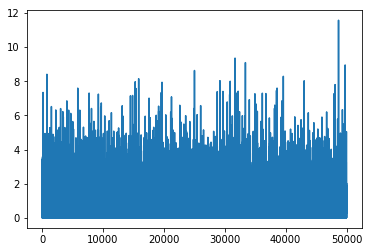

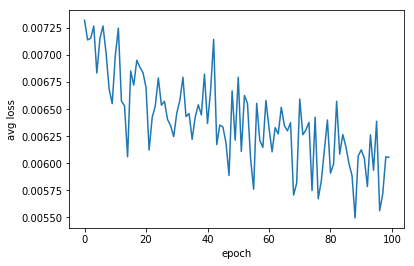

In [30]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 1e-6)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    print('Starting the training ...')
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        for i in range(num_iter):
            model.hidden3 = (model.hidden3[0].detach(), model.hidden3[1].detach())
            model.hidden2_1 = (model.hidden2_1[0].detach(), model.hidden2_1[1].detach())
            model.hidden2_2 = (model.hidden2_2[0].detach(), model.hidden2_2[1].detach())
            model.hidden2_3 = (model.hidden2_3[0].detach(), model.hidden2_3[1].detach())
            model.zero_grad()
            X,Y = next(ACTd)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float().cuda())
            X = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y])).cuda())

            y_hat = model(X)
#             print(eph, i, y_hat)
            loss = F.cross_entropy(y_hat, Y)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        #evaluating model accuracy
        acc = evaluate_accuracy(model, test_split)
        print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}% \n'.format(eph, avg_loss, acc))
    return loss_values, avg_loss_values


loss_vals, avg_loss_vals = train(model0, 100, 1000, 2, 100) #100eph_8e-6, 
plt.figure()
plt.plot(loss_vals)
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel('epoch')
plt.ylabel('avg loss')

In [29]:
avg_loss_v1 = avg_loss_vals

In [32]:
avg_loss_v1 += avg_loss_vals

Text(0,0.5,'avg loss')

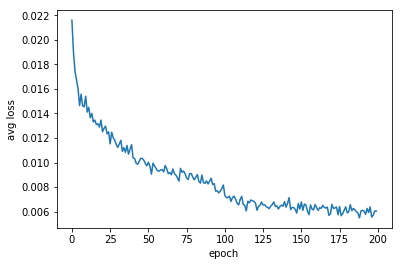

In [33]:
plt.plot(avg_loss_v1)
plt.xlabel('epoch')
plt.ylabel('avg loss')

In [34]:
# saving the model
def save_model(model_name, path, model):
    p = path+'/'+model_name
    print('saving at {}'.format(p))
    torch.save(model.state_dict(), p)
    print('saved at {}'.format(p))

In [35]:
save_model('LSTMClassifierX3_c7.pth', './checkpoints', model0)

saving at ./checkpoints/LSTMClassifierX3_c7.pth
saved at ./checkpoints/LSTMClassifierX3_c7.pth


In [36]:
mtest = LSTMClassifier(75, 512, 7, 1, 2, 3).cuda()
mtest.load_state_dict(torch.load('./checkpoints/LSTMClassifierX3_c7.pth'))

In [38]:
mtest.lstm3.weight_hh_l0

Parameter containing:
 3.9143e-02  2.4818e-02  3.2468e-02  ...   8.5511e-03 -1.7184e-02 -3.2849e-02
-1.3644e-02 -4.0704e-02  3.7073e-02  ...  -3.0386e-02 -2.2615e-02 -4.2696e-02
-2.8556e-02 -3.3357e-03  3.7336e-02  ...   5.2892e-03 -1.9198e-02  3.0822e-02
                ...                   ⋱                   ...                
-2.1083e-02  3.5893e-02 -1.1259e-03  ...   2.0177e-02  3.5760e-02  3.1273e-02
 5.1477e-03 -2.0578e-02  4.1886e-02  ...  -1.3133e-02  2.3866e-02 -2.6527e-02
-2.6014e-04  9.1317e-03  2.4725e-03  ...   2.3441e-02  1.9406e-02  1.0368e-02
[torch.cuda.FloatTensor of size 2048x512 (GPU 0)]